In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install geopandas
!pip install folium
!pip install seaborn
!pip install geopy
!pip install turfpy
!pip install geojson

In [ ]:
import math
import pandas as pd     
import numpy as np
import requests
import geopandas as gpd   
import matplotlib.pyplot as plt    
import seaborn as sns   
import folium
from folium import Marker
from folium.plugins import MarkerCluster, HeatMap
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union

In [ ]:
filepath = '/content/drive/MyDrive/omdena-poland/task-1a/pl_2018_20200213 (1).csv'
lucas_df = pd.read_csv(filepath)
print(lucas_df.shape)
lucas_df.head()

(23087, 97)


<ipython-input-4-d676946d9498>:2: DtypeWarning: Columns (0,32) have mixed types. Specify dtype option on import or set low_memory=False.
  lucas_df = pd.read_csv(filepath)


,POINT_ID,NUTS0,NUTS1,NUTS2,NUTS3,TH_LAT,TH_LONG,OFFICE_PI,EX_ANTE,SURVEY_DATE,...,SOIL_BLK_20_30_TAKEN,STANDARD_SAMPLE,SOIL_STD_TAKEN,ORGANIC_SAMPLE,SOIL_ORG_DEPTH_CANDO,PHOTO_POINT,PHOTO_NORTH,PHOTO_EAST,PHOTO_SOUTH,PHOTO_WEST
0,52143064,PL,PL8,PL82,PL822,49.999992,22.523955,0.0,0.0,02/08/18,...,8.0,0.0,8.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0
1,52143116,PL,PL8,PL81,PL812,50.459587,22.647285,0.0,0.0,29/09/18,...,8.0,0.0,8.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0
2,52143388,PL,PL8,PL84,PL842,52.859583,23.344372,0.0,0.0,27/06/18,...,8.0,0.0,8.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0
3,52143474,PL,PL8,PL84,PL841,53.616991,23.584724,0.0,0.0,09/05/18,...,8.0,1.0,1.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0
4,47923082,PL,PL5,PL51,PL517,50.656433,16.670903,0.0,0.0,22/08/18,...,8.0,0.0,8.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#The get data fuction takes a really long time to run as it get the state, and county value for over 5000 points
# There might be ways to improve this code cell and make it faster 
# lucas_df.info()
#Function to filter the croplands and get a certain cropland cover percentage
def get_crops(df):
  indexes_to_drop = []
  for ind in df.index:
    if len(df['LC1'][ind])!=0:
      if df['LC1'][ind][0]!='B':
        indexes_to_drop.append(ind)
  #drop unwanted rows using their index
  df.drop(df.index[indexes_to_drop], inplace=True)
  #extra filtering process to reduce the number of points
  df = df[df['LC1_PERC']>=70]
  df = df[df['LU1']=='U111']
  return df

#Function to get the county, and state features of the lat and long points
def get_location(lat, lon):
    url = f'https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&accept-language=en&zoom=11'
    try:
        result = requests.get(url=url)
        result_json = result.json()
        return result_json
        # return result_json['address']['state'], result_json['address']['county']
    except:
        return None

def get_data(df):
  columns = ['TH_LAT', 'TH_LONG', 'LC1', 'LC1_PERC', 'LU1', 'LU1_PERC']
  df = lucas_df[columns]
  df = df.dropna()
  df = get_crops(df)

  state_result = []
  county_result = []
  lat_result = []
  lon_result = []
  for ind, row in df.iterrows():
    lat = str(row['TH_LAT'])
    lon = str(row['TH_LONG'])
    result = get_location(str(row['TH_LAT']), str(row['TH_LONG']))
    if result is not None:
      lat_result.append(lat)
      lon_result.append(lon)
      state_result.append(result['address']['state'])
      #Some counties are saved in city key value
      try:
        county_result.append(result['address']['county'])
      except:
        county_result.append(result['address']['city'])
  
  final_df = pd.DataFrame(list(zip(lat_result, lon_result, county_result, state_result)),
               columns =['LAT', 'LON', 'COUNTY', 'STATE'])


  return final_df


df = get_data(lucas_df)
print(df.shape)
df.head()

(5039, 4)


,LAT,LON,COUNTY,STATE
0,49.999991692,22.523954953,Przeworsk County,Subcarpathian Voivodeship
1,53.463956144,17.104131138,Złotów County,Greater Poland Voivodeship
2,50.910953918,18.796913024,Kłobuck County,Silesian Voivodeship
3,49.838734283,18.626610947,Cieszyn County,Silesian Voivodeship
4,51.853363465,19.010255125,Poddębice County,Łódzkie Voivodship


In [ ]:
from google.colab import files
# df.to_csv('cropland.csv')
# files.download('cropland.csv')

path = '/content/drive/MyDrive/omdena-poland/task-1a/cropland.csv'
with open(path, 'w', encoding='utf-8-sig') as f:
  df.to_csv(f)

In [ ]:
# Load shape file
shapefile_all = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp")
# change CRS to epsg 4326
shapefile_all_transformed = shapefile_all.to_crs(epsg=4326)
print(shapefile_all_transformed.crs)
shapefile_all_transformed.tail()

EPSG:4326


,CELLCODE,EOFORIGIN,NOFORIGIN,geometry
4042,10kmE532N315,5320000,3150000,"POLYGON ((24.20789 50.58535, 24.23500 50.67329..."
4043,10kmE532N316,5320000,3160000,"POLYGON ((24.23500 50.67329, 24.26224 50.76123..."
4044,10kmE532N317,5320000,3170000,"POLYGON ((24.26224 50.76123, 24.28961 50.84915..."
4045,10kmE532N318,5320000,3180000,"POLYGON ((24.28961 50.84915, 24.31711 50.93706..."
4046,10kmE532N319,5320000,3190000,"POLYGON ((24.31711 50.93706, 24.34474 51.02496..."


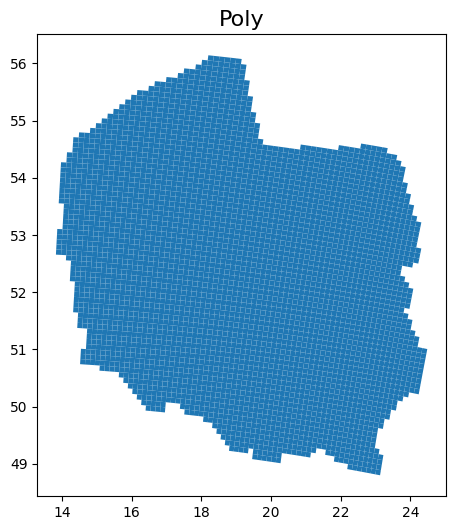

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Poly", fontsize=16)
poly = shapefile_all_transformed.plot(ax=ax)
plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/omdena-poland/task-1a/cropland.csv')
df.head()

,Unnamed: 0,LAT,LON,COUNTY,STATE
0,0,49.999992,22.523955,Przeworsk County,Subcarpathian Voivodeship
1,1,53.463956,17.104131,Złotów County,Greater Poland Voivodeship
2,2,50.910954,18.796913,Kłobuck County,Silesian Voivodeship
3,3,49.838734,18.626611,Cieszyn County,Silesian Voivodeship
4,4,51.853363,19.010255,Poddębice County,Łódzkie Voivodship


In [ ]:
# Interactive visualization of polygon using the library folium

m_1 = folium.Map(location=[df.LAT.mean(), df.LON.mean()], tiles='cartodbpositron',
                 zoom_start=6, 
                 control_scale=True)
m_1

In [ ]:
df['STATE'].value_counts()

Lublin Voivodeship                 538
Łódzkie Voivodship                 435
Greater Poland Voivodeship         423
Opole Voivodeship                  416
Podlaskie Voivodeship              391
Masovian Voivodeship               381
Lower Silesian Voivodeship         370
Kuyavian-Pomeranian Voivodeship    370
Warmian-Masurian Voivodeship       345
Silesian Voivodeship               264
West Pomeranian Voivodeship        237
Świętokrzyskie Voivodeship         223
Subcarpathian Voivodeship          189
Lesser Poland Voivodeship          189
Pomeranian Voivodeship             153
Lubusz Voivodeship                 115
Name: STATE, dtype: int64

In [ ]:
# m_2 = folium.Map([lat, long], tiles='cartodbpositron', zoom_start=7)
m_2 = folium.Map(location=[df.LAT.mean(), df.LON.mean()], tiles='cartodbpositron',
                 zoom_start=6, 
                 control_scale=True)

# # Your code here: Add a heatmap to the map
HeatMap(data=df[['LAT', 'LON']], radius=10).add_to(m_2)

m_2


!




In [ ]:
#We will be focusing on the two major zones as seen on our map, OPOLE and HOLY CROSS VOIVODESHIP (STATE)
# print(df['STATE'].unique()) 
#'Opole Voivodeship'
#'Świętokrzyskie Voivodeship'

opole_df = df[df['STATE']=='Opole Voivodeship']
holy_cross_df = df[df['STATE']=='Świętokrzyskie Voivodeship']

print(opole_df.shape, holy_cross_df.shape)

(416, 5) (223, 5)


In [ ]:
#Markers in opole state

m_3 = folium.Map(location=[opole_df.LAT.mean(), opole_df.LON.mean()],
                 zoom_start=9, 
                 control_scale=True)

for idx, row in opole_df.iterrows():
  Marker([row['LAT'], row['LON']]).add_to(m_3)

m_3.fit_bounds([opole_df.LAT.mean(), opole_df.LON.mean()])

m_3

In [ ]:
#Markers in Holy Cross state

m_4 = folium.Map(location=[holy_cross_df.LAT.mean(), holy_cross_df.LON.mean()], 
                 zoom_start=9, 
                 control_scale=True)

for idx, row in holy_cross_df.iterrows():
  Marker([row['LAT'], row['LON']]).add_to(m_4)

m_4.fit_bounds([holy_cross_df.LAT.mean(), holy_cross_df.LON.mean()])

m_4

In [ ]:
opole_df['COUNTY'].value_counts()

Nysa County                54
Głubczyce County           45
Olesno County              43
Namysłów County            40
Kluczbork County           40
Kędzierzyn-Koźle County    38
Prudnik County             36
Brzeg County               34
Strzelce County            32
Opole County               28
Krapkowice County          21
Opole                       5
Name: COUNTY, dtype: int64

In [ ]:
holy_cross_df['COUNTY'].value_counts()

Jędrzejów County       67
Opatów County          47
Włoszczowa County      22
Pińczów County         20
Ostrowiec County       15
Kielce County          10
Busko County            9
Starachowice County     7
Końskie County          7
Kazimierza County       7
Sandomierz County       6
Staszów County          5
Kielce                  1
Name: COUNTY, dtype: int64

In [ ]:
#Markers in opole

m_5 = folium.Map(location=[opole_df.LAT.mean(), opole_df.LON.mean()], tiles="Stamen Terrain",
                 zoom_start=9, 
                 control_scale=True)

fmc = MarkerCluster()
for idx, row in opole_df.iterrows():
    if not math.isnan(row['LON']) and not math.isnan(row['LAT']):
        fmc.add_child(folium.Marker([row['LAT'], row['LON']]))

m_5.add_child(fmc)

HeatMap(data=opole_df[['LAT', 'LON']], radius=10).add_to(m_5)

m_5.fit_bounds([opole_df.LAT.mean(), opole_df.LON.mean()])

m_5

In [ ]:
#Markers in holy cross county

m_6 = folium.Map(location=[holy_cross_df.LAT.mean(), holy_cross_df.LON.mean()], tiles="Stamen Terrain",
                 zoom_start=9, 
                 control_scale=True)

fmc = MarkerCluster()
for idx, row in holy_cross_df.iterrows():
    if not math.isnan(row['LON']) and not math.isnan(row['LAT']):
        fmc.add_child(folium.Marker([row['LAT'], row['LON']]))

m_6.add_child(fmc)

HeatMap(data=holy_cross_df[['LAT', 'LON']], radius=10).add_to(m_6)

m_6.fit_bounds([holy_cross_df.LAT.mean(), holy_cross_df.LON.mean()])

m_6

**Get points on Shapefile**

In [ ]:
print(len(opole_df), len(holy_cross_df))
print(shapefile_all_transformed.crs)
print(len(shapefile_all_transformed))
shapefile_all_transformed.tail()

416 223
EPSG:4326
4047


,CELLCODE,EOFORIGIN,NOFORIGIN,geometry
4042,10kmE532N315,5320000,3150000,"POLYGON ((24.20789 50.58535, 24.23500 50.67329..."
4043,10kmE532N316,5320000,3160000,"POLYGON ((24.23500 50.67329, 24.26224 50.76123..."
4044,10kmE532N317,5320000,3170000,"POLYGON ((24.26224 50.76123, 24.28961 50.84915..."
4045,10kmE532N318,5320000,3180000,"POLYGON ((24.28961 50.84915, 24.31711 50.93706..."
4046,10kmE532N319,5320000,3190000,"POLYGON ((24.31711 50.93706, 24.34474 51.02496..."


In [ ]:
# shapefile_all_transformed['EOFORIGIN'].unique()
print(shapefile_all_transformed['geometry'][0])

POLYGON ((13.829501555648427 52.65765635908251, 13.837347859278308 52.747377579776455, 13.985236864414588 52.74254505468579, 13.977089674117572 52.65283514106149, 13.829501555648427 52.65765635908251))


In [ ]:
opole_gdf = gpd.GeoDataFrame(
    opole_df, geometry=gpd.points_from_xy(opole_df.LON, opole_df.LAT))

holy_cross_gdf = gpd.GeoDataFrame(
    holy_cross_df, geometry=gpd.points_from_xy(holy_cross_df.LON, holy_cross_df.LAT))

opole_gdf.crs = "EPSG:4326"
holy_cross_gdf.crs = "EPSG:4326"

# opole_gdf = opole_gdf.to_crs(epsg=4326)
# holy_cross_gdf = holy_cross_gdf.to_crs(epsg=4326)


print(len(opole_gdf), len(holy_cross_gdf))
# opole_gdf.head()

416 223


In [ ]:
print(opole_gdf.crs)
hc_gdf = gpd.sjoin(holy_cross_gdf,shapefile_all_transformed,how="inner", predicate='within')
op_gdf = gpd.sjoin(opole_gdf,shapefile_all_transformed,how="inner", predicate='within')

hc_gdf.shape, op_gdf.shape

EPSG:4326


((223, 10), (416, 10))

In [ ]:
hc_gdf.head()

,Unnamed: 0,LAT,LON,COUNTY,STATE,geometry,index_right,CELLCODE,EOFORIGIN,NOFORIGIN
169,169,50.520341,20.432195,Pińczów County,Świętokrzyskie Voivodeship,POINT (20.43220 50.52034),2679,10kmE505N309,5050000,3090000
241,241,50.464475,20.448226,Pińczów County,Świętokrzyskie Voivodeship,POINT (20.44823 50.46447),2679,10kmE505N309,5050000,3090000
600,600,50.484800,20.424259,Pińczów County,Świętokrzyskie Voivodeship,POINT (20.42426 50.48480),2679,10kmE505N309,5050000,3090000
1060,1060,50.456877,20.332561,Pińczów County,Świętokrzyskie Voivodeship,POINT (20.33256 50.45688),2679,10kmE505N309,5050000,3090000
1972,1972,50.510200,20.344357,Pińczów County,Świętokrzyskie Voivodeship,POINT (20.34436 50.51020),2679,10kmE505N309,5050000,3090000


In [ ]:
hc_gdf['index_right'].value_counts()

3169    11
2556    11
3109    10
2494     9
2679     8
        ..
2738     1
2498     1
2861     1
3111     1
2683     1
Name: index_right, Length: 80, dtype: int64

In [ ]:
print(op_gdf['index_right'].value_counts())

1609    11
1611    10
1689     9
1608     9
1681     9
        ..
1341     1
1889     1
1269     1
1131     1
1538     1
Name: index_right, Length: 100, dtype: int64

In [ ]:
max_opole = op_gdf[op_gdf['index_right']==1609]
max_opole.head()

,Unnamed: 0,LAT,LON,COUNTY,STATE,geometry,index_right,CELLCODE,EOFORIGIN,NOFORIGIN
592,592,50.121560,17.973684,Głubczyce County,Opole Voivodeship,POINT (17.97368 50.12156),1609,10kmE488N303,4880000,3030000
598,598,50.129313,17.862359,Głubczyce County,Opole Voivodeship,POINT (17.86236 50.12931),1609,10kmE488N303,4880000,3030000
1865,1865,50.180972,17.899116,Głubczyce County,Opole Voivodeship,POINT (17.89912 50.18097),1609,10kmE488N303,4880000,3030000
1871,1871,50.139420,17.976686,Głubczyce County,Opole Voivodeship,POINT (17.97669 50.13942),1609,10kmE488N303,4880000,3030000
2209,2209,50.145247,17.893165,Głubczyce County,Opole Voivodeship,POINT (17.89317 50.14525),1609,10kmE488N303,4880000,3030000


In [ ]:
max_hc = hc_gdf[hc_gdf['index_right']==3169]
max_hc.head()

,Unnamed: 0,LAT,LON,COUNTY,STATE,geometry,index_right,CELLCODE,EOFORIGIN,NOFORIGIN
264,264,50.843714,21.598507,Opatów County,Świętokrzyskie Voivodeship,POINT (21.59851 50.84371),3169,10kmE513N314,5130000,3140000
771,771,50.802586,21.645744,Opatów County,Świętokrzyskie Voivodeship,POINT (21.64574 50.80259),3169,10kmE513N314,5130000,3140000
1013,1013,50.793392,21.557080,Opatów County,Świętokrzyskie Voivodeship,POINT (21.55708 50.79339),3169,10kmE513N314,5130000,3140000
1041,1041,50.808277,21.589597,Opatów County,Świętokrzyskie Voivodeship,POINT (21.58960 50.80828),3169,10kmE513N314,5130000,3140000
1673,1673,50.861433,21.602968,Opatów County,Świętokrzyskie Voivodeship,POINT (21.60297 50.86143),3169,10kmE513N314,5130000,3140000


In [ ]:
# Opole Index at index 1609
m_7 = folium.Map(location=[50.12156, 17.97368], tiles="Stamen Terrain",
                 zoom_start=12, 
                 control_scale=True)
 

sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[1609]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[1609]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_7)

for idx, row in max_opole.iterrows():
  lon = row['geometry'].x
  lat = row['geometry'].y
  Marker([lat, lon]).add_to(m_7)


m_7

In [ ]:
# Holy Cross at index 3169
m_8 = folium.Map(location=[50.80828, 21.58960], tiles="Stamen Terrain",
                 zoom_start=12, 
                 control_scale=True)


sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[3169]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[3169]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_8)

for idx, row in max_hc.iterrows():
  lon = row['geometry'].x
  lat = row['geometry'].y
  Marker([lat, lon]).add_to(m_8)


m_8

In [ ]:
max_hc2 = hc_gdf[hc_gdf['index_right']==2556]
max_hc2.head()

,Unnamed: 0,LAT,LON,COUNTY,STATE,geometry,index_right,CELLCODE,EOFORIGIN,NOFORIGIN
368,368,50.570757,20.072296,Jędrzejów County,Świętokrzyskie Voivodeship,POINT (20.07230 50.57076),2556,10kmE503N310,5030000,3100000
462,462,50.631952,20.199868,Jędrzejów County,Świętokrzyskie Voivodeship,POINT (20.19987 50.63195),2556,10kmE503N310,5030000,3100000
1007,1007,50.588541,20.076140,Jędrzejów County,Świętokrzyskie Voivodeship,POINT (20.07614 50.58854),2556,10kmE503N310,5030000,3100000
1785,1785,50.560835,20.184306,Jędrzejów County,Świętokrzyskie Voivodeship,POINT (20.18431 50.56083),2556,10kmE503N310,5030000,3100000
2322,2322,50.563325,20.156308,Jędrzejów County,Świętokrzyskie Voivodeship,POINT (20.15631 50.56333),2556,10kmE503N310,5030000,3100000


In [ ]:
# Holy Cross at index 2556
max_hc2 = hc_gdf[hc_gdf['index_right']==2556]

m_9 = folium.Map(location=[50.58359, 20.13217], tiles="Stamen Terrain",
                 zoom_start=12, 
                 control_scale=True)


sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[2556]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[2556]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_9)

for idx, row in max_hc2.iterrows():
  lon = row['geometry'].x
  lat = row['geometry'].y
  Marker([lat, lon]).add_to(m_9)

m_9

**There are 3 possible indexes based on the 10km shapefile we have, for Opole we have one location with the highest number of points, nad two locations for holy cross. All locations are plotted on our maps, indexes represent index locations on our poland 10km shapefile **



*   Opole - Index [1609]
*   Holy Cross - Index [3169, 3109]



In [ ]:
#Centroids of clusters of 5km diameter
# max_hc2, max_hc, max_opole
max_opole.head()

,Unnamed: 0,LAT,LON,COUNTY,STATE,geometry,index_right,CELLCODE,EOFORIGIN,NOFORIGIN
592,592,50.121560,17.973684,Głubczyce County,Opole Voivodeship,POINT (17.97368 50.12156),1609,10kmE488N303,4880000,3030000
598,598,50.129313,17.862359,Głubczyce County,Opole Voivodeship,POINT (17.86236 50.12931),1609,10kmE488N303,4880000,3030000
1865,1865,50.180972,17.899116,Głubczyce County,Opole Voivodeship,POINT (17.89912 50.18097),1609,10kmE488N303,4880000,3030000
1871,1871,50.139420,17.976686,Głubczyce County,Opole Voivodeship,POINT (17.97669 50.13942),1609,10kmE488N303,4880000,3030000
2209,2209,50.145247,17.893165,Głubczyce County,Opole Voivodeship,POINT (17.89317 50.14525),1609,10kmE488N303,4880000,3030000


In [ ]:
def get_5km_polygons(df):
  df = df.copy()
  df['xcoord'] = df.geometry.x
  df['ycoord'] = df.geometry.y

  #Cluster nearby points together
  coords = df[['xcoord','ycoord']].values #Create a numpy array
  db = DBSCAN(eps=5/6371, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) #Cluster the points. eps is max distance to cluster points together
  cluster_labels = pd.Series(db.labels_).rename('cluster') #Extract cluster labels
  df['cluster'] = cluster_labels.values

  #Create convex hulls from each cluster
  hulls = [] #A list to hold clusterids and convex hull geometries
  for clusterid, frame in df.loc[df['cluster']!=-1].groupby('cluster'): #For each cluster group except -1
      geom = unary_union(frame.geometry.tolist()).convex_hull #Create one multipoint and convex hull it
      hulls.append([clusterid, geom])

  # hulls
  df2 = pd.DataFrame.from_records(data=hulls, columns=['cluster','geometry'])
  df2 = gpd.GeoDataFrame(data=df2, geometry=df2['geometry'], crs=df.crs)
  df2 = df2.to_crs("epsg:32662")

  #Add a buffer to the polygon
  max = df2['geometry'].buffer(350)
  max = max.to_crs(crs=4326)
  df2['geometry'] = max

  return df, df2

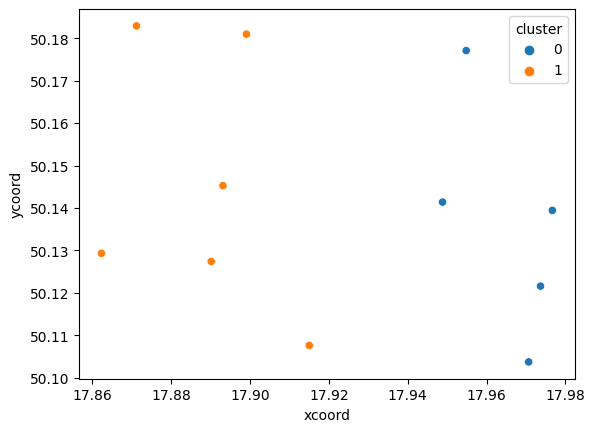

In [ ]:
max_opole_5km, max_opole_5km_polygon_df = get_5km_polygons(max_opole)
# print(max_opole_5km.cluster.unique())
sns.scatterplot(x='xcoord', y='ycoord', data=max_opole_5km, hue='cluster')
plt.show()

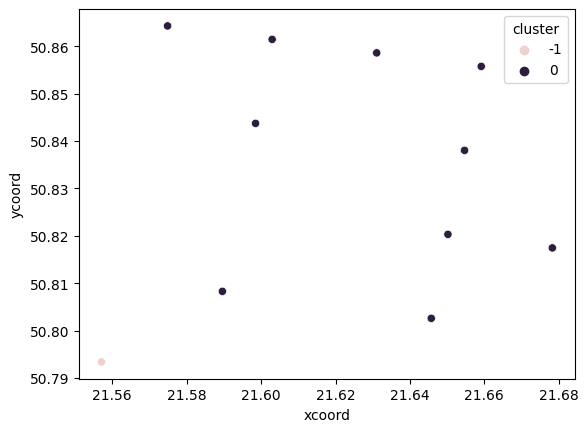

In [ ]:
max_hc_5km, max_hc_5km_polygon_df = get_5km_polygons(max_hc)
sns.scatterplot(x='xcoord', y='ycoord', data=max_hc_5km, hue='cluster')
plt.show()

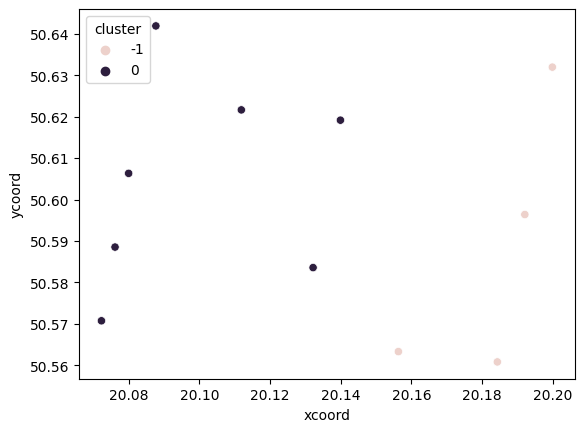

In [ ]:
max_hc2_5km, max_hc2_5km_polygon_df = get_5km_polygons(max_hc2)
# print(max_opole_5km.cluster.unique())
sns.scatterplot(x='xcoord', y='ycoord', data=max_hc2_5km, hue='cluster')
plt.show()

In [ ]:
# Opole Index at index 1609
m_10 = folium.Map(location=[50.12156, 17.97368], tiles="Stamen Terrain",
                 zoom_start=12, 
                 control_scale=True)
 

sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[1609]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[1609]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_10)

sim_geo = gpd.GeoSeries(max_opole_5km_polygon_df['geometry'])
sim_geo = gpd.GeoSeries(max_opole_5km_polygon_df['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'yellow'})
geo_j.add_to(m_10)

for idx, row in max_opole.iterrows():
  lon = row['geometry'].x
  lat = row['geometry'].y
  Marker([lat, lon]).add_to(m_10)


m_10

In [ ]:
# Holy Cross at index 3169
m_11 = folium.Map(location=[50.80828, 21.58960], tiles="Stamen Terrain",
                 zoom_start=12, 
                 control_scale=True)


sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[3169]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[3169]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_11)

sim_geo = gpd.GeoSeries(max_hc_5km_polygon_df['geometry'])
sim_geo = gpd.GeoSeries(max_hc_5km_polygon_df['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'yellow'})
geo_j.add_to(m_11)

for idx, row in max_hc.iterrows():
  lon = row['geometry'].x
  lat = row['geometry'].y
  Marker([lat, lon]).add_to(m_11)


m_11

In [ ]:
# Holy Cross at index 2556
max_hc2 = hc_gdf[hc_gdf['index_right']==2556]

m_12 = folium.Map(location=[50.58359, 20.13217], tiles="Stamen Terrain",
                 zoom_start=12, 
                 control_scale=True)


sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[2556]['geometry'])
sim_geo = gpd.GeoSeries(shapefile_all_transformed.iloc[2556]['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green'})
geo_j.add_to(m_12)

sim_geo = gpd.GeoSeries(max_hc2_5km_polygon_df['geometry'])
sim_geo = gpd.GeoSeries(max_hc2_5km_polygon_df['geometry']).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'yellow'})
geo_j.add_to(m_12)

for idx, row in max_hc2.iterrows():
  lon = row['geometry'].x
  lat = row['geometry'].y
  Marker([lat, lon]).add_to(m_12)

m_12